In [1]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,TargetEncoder
import pandas as pd

import random
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans


In [2]:
def preprocess(X,drop=False,X_test = None):
    """
    pasa X_test sólo al preprocesar X
    """
    if X_test is not None:
        cols_mas_unique_en_train = ["subvillage","installer","funder","scheme_name","wpt_name",
                                    "region_code","ward","extraction_type"]
        for i in cols_mas_unique_en_train:
            unicos_en_test = X_test[i].unique().tolist()
            X[i] = [x if x in unicos_en_test else np.nan for x in X[i].values]
            #X[i] = [x if x in unicos_en_test else x.split(" ")[0] for x in X[i].values]

    for i in X.select_dtypes(include = "O").columns:
        X[i] = X[i].astype("category")

    #Fechas------------------------------------------------------------------------ 
    X.date_recorded = X.date_recorded.astype("O")
    X.date_recorded = pd.to_datetime(X.date_recorded)
    X['date_recorded'] = (X.date_recorded.max() - X.date_recorded).dt.days

    #population_binned optbinning------------------------------------------------------------------------ 
    X["population_binned"] = X["population"].copy()
    X.loc[X["population"].between(-np.inf,1.5),"population_binned"] = "bin0"
    X.loc[X["population"].between(1.5,np.inf),"population_binned"] = "bin1"
    X["population_binned"] = X["population_binned"].astype("category")
    #Marcar VALORES sin sentido como nan para ser imputados------------------------------------------------------------------------  
    X["construction_year"] = X.construction_year.max()-X.construction_year
    X.loc[X["construction_year"] ==2013,"construction_year"] = np.nan # si da 2013 la resta fue max - cero
    #Drop list ------------------------------------------------------------------------ 

    drop_list  = ["amount_tsh","num_private","recorded_by"]   
    X.drop(drop_list,axis=1,inplace=True)
    #Clusters de latitud y longitud, se hace fuera para que X_test sea transform sin fit------------------------------------------------------------------------
    #clustering = KMeans(n_clusters=20)
    #X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
    
    return X

In [5]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv").status_group.values
it_imp2 = KNNImputer()
for i in X.select_dtypes(include = "O").columns:
    X[i] = X[i].astype("category")

le= LabelEncoder()
y= le.fit_transform(y)
X = preprocess(X)
# no entra en preprocessing para poder hacerle al test solo predict
clustering = KMeans(n_clusters=20)
X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
preprocessing = ColumnTransformer([
    ('ordinal_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =np.nan), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)

X = pd.DataFrame(data=preprocessing.fit_transform(X), columns=preprocessing.get_feature_names_out())
X = pd.DataFrame(data=it_imp2.fit_transform(X), columns=it_imp2.get_feature_names_out())

rf = RandomForestClassifier(bootstrap=False,max_depth=20,max_features="sqrt",min_samples_leaf=2,n_estimators=150,n_jobs=-1)
rf.fit(X.drop("remainder__id",axis=1),y)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       n_estimators=150, n_jobs=-1)

In [6]:
import shap 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)



X_test_summary_sin_id = X_test.drop("remainder__id",axis=1).sample(100)
X_test_summary = shap.sample(X_test_summary_sin_id, 100) 

explainer = shap.KernelExplainer(rf.predict,X_test_summary_sin_id)

  0%|          | 0/100 [00:00<?, ?it/s]

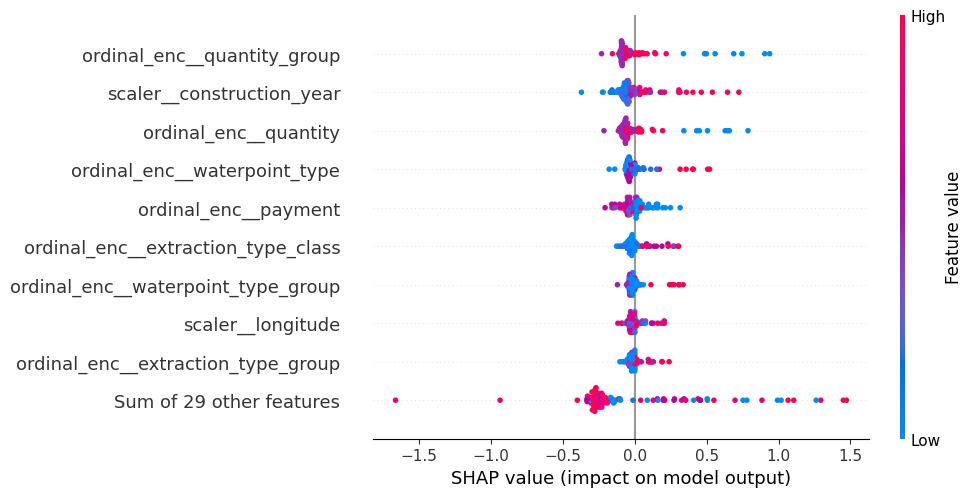

In [7]:
shap_values = explainer(X_test_summary_sin_id)
shap.plots.beeswarm(shap_values) 

  0%|          | 0/100 [00:00<?, ?it/s]

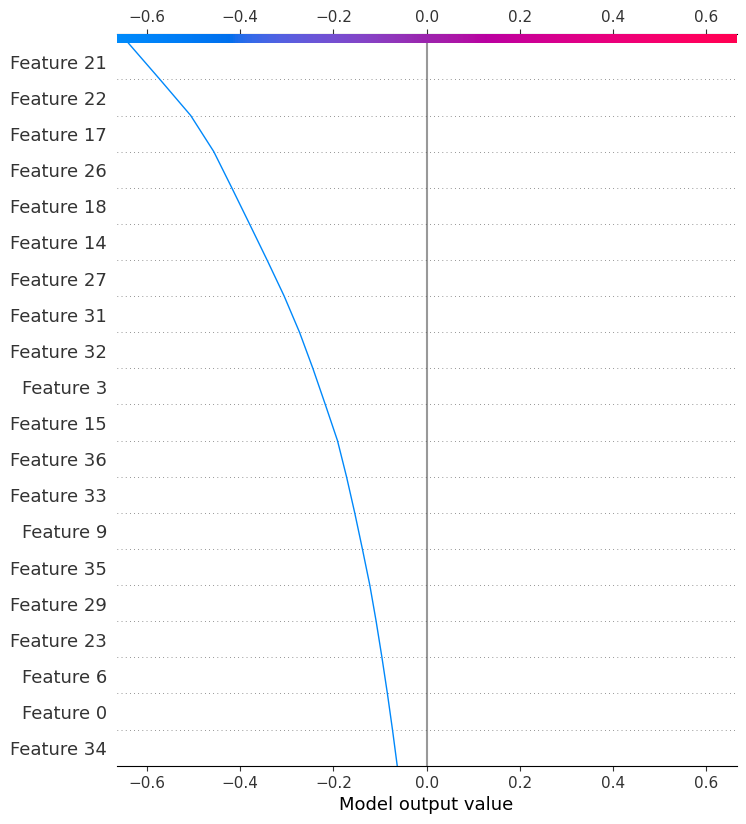

In [9]:
shap_values = explainer.shap_values(X_test_summary_sin_id)
shap.decision_plot(base_value=0,shap_values=shap_values[0])#exp_val,features

<AxesSubplot: xlabel='date_recorded'>

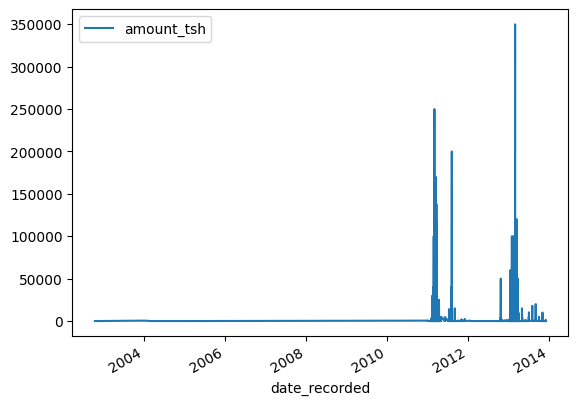

In [15]:
import pandas as pd
X = pd.read_csv("In/Training_set_values.csv")
X.date_recorded = X.date_recorded.astype("O")
X.date_recorded = pd.to_datetime(X.date_recorded)

<AxesSubplot: ylabel='Frequency'>

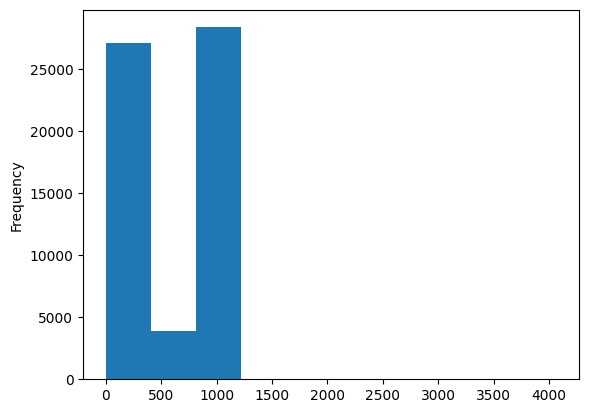

In [16]:
X['date_recorded'] = (X.date_recorded.max() - X.date_recorded).dt.days
X['date_recorded'].plot(kind="hist")
